# Exploration of the phase diagram of the Polymer dynamics model

In [ ]:
import os
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
from tqdm.notebook import tqdm

## Load model

In [2]:
from omegaconf import OmegaConf
from polymer_dynamics_temperature import build_model
# path = "outputs/2025_04_18-11_06_46"  # working checkpoing with (W and M having dependence on T and Wi)
path = "outputs/2025_04_19-13_26_20"  # working checkpoint with (W and M having dependence on T and F)
config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
model_template = build_model(config)
trained_model = eqx.tree_deserialise_leaves(os.path.join(path, "model.eqx"), model_template)

## Build potential function

In [3]:
@jax.jit
def V(z1, z2, z3, T, F):
    args = jnp.array([T, F])
    coords = jnp.array([z1, z2, z3])
    return trained_model.potential(coords, args)

## Visualisation of the potential

In [4]:
z1_min, z1_max = -4, 2.5
z2_min, z2_max = -3, 3
z3_min, z3_max = -6, 6
num_samples_aux_dimension = 128  # number of samples to take infimum over

@jax.jit
def V_12(z1, z2, T, F):
    z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
    return jnp.min(jax.vmap(V, (None, None, 0, None, None))(z1, z2, z3_test_range, T, F))

In [5]:
from ipywidgets import interact, FloatSlider

num_grid = 100
num_levels = 200
level_start = 0.0
level_end = 500.0
custom_levels = jnp.linspace(level_start, level_end, num_levels)

def get_V_12(T, F):
    z1_range = jnp.linspace(z1_min, z1_max, num_grid)
    z2_range = jnp.linspace(z2_min, z2_max, num_grid)
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    V12_grid = jax.vmap(V_12, in_axes=(0, 0, None, None))(Z1.ravel(), Z2.ravel(), T, F).reshape(Z1.shape)
    return Z1, Z2, V12_grid


def plot_potential_contour(T, F):
    # Get the Z1, Z2 meshgrid and V12_grid values
    Z1, Z2, V12_grid = get_V_12(T=T, F=F)

    # Clip values to avoid extremely high values that distort the visualization
    # V12_grid = jnp.clip(V12_grid, a_min=0.0, a_max=level_end)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create contour plot with the custom levels
    contour = ax.contour(Z1, Z2, V12_grid, levels=custom_levels)
    contourf = ax.contourf(Z1, Z2, V12_grid, levels=custom_levels, cmap='viridis', alpha=0.7)

    # Add labels and title
    ax.set_xlabel(r'$Z_1$')
    ax.set_ylabel(r'$Z_2$')
    ax.set_title(f'Potential Landscape $V_{{12}}$ (T={T:.2f}, F={F:.2f})')

    # Add a color bar
    cbar = fig.colorbar(contourf, ax=ax)
    cbar.set_label('Potential Energy')

    plt.tight_layout()
    plt.show()

# Create sliders for T and F
interact(plot_potential_contour,
         T=FloatSlider(value=1.5, min=0.01, max=10.0, step=0.1, description='T'),
         F=FloatSlider(value=0.0, min=-1.1, max=1.1, step=0.1, description='F'));

interactive(children=(FloatSlider(value=1.5, description='T', max=10.0, min=0.01), FloatSlider(value=0.0, desc…

## Method 1: Use Euler Characteristics

### Prepare Euler char data

In [6]:
from skimage.measure import euler_number   # works for 3-D volumes
from scipy.ndimage import gaussian_filter

#### Euler Char for single instance of T, F

In [30]:
num_samples = 64

# Create meshgrid
z1_vals = jnp.linspace(z1_min, z1_max, num_samples)
z2_vals = jnp.linspace(z2_min, z2_max, num_samples)
z3_vals = jnp.linspace(z3_min, z3_max, num_samples)

z1_grid, z2_grid, z3_grid = jnp.meshgrid(z1_vals, z2_vals, z3_vals, indexing='ij')
points_3d = jnp.stack([z1_grid, z2_grid, z3_grid], axis=-1)
points = points_3d.reshape(-1, 3)  # shape: [num_points, 3]

In [31]:
def euler_curve(Vgrid, thresholds, sigma=None):
    Vg = gaussian_filter(Vgrid, sigma=sigma) if sigma else Vgrid
    return np.array([euler_number(Vg <= a, connectivity=3) for a in thresholds])

def get_chi(T, F, offset=50.0, num_levels=512, sigma=1.5):
    V_grid = jax.vmap(V, (0, 0, 0, None, None))(points[:, 0], points[:, 1], points[:, 2], T, F)                 # shape: [num_points]
    V_grid_3d = V_grid.reshape(points_3d.shape[:-1])

    vmin, vmax = V_grid.min()+1, V_grid.min()+offset
    thresholds = jnp.linspace(vmin, vmax, num_levels)
    chi = euler_curve(V_grid_3d, thresholds, sigma=sigma)
    return thresholds, chi

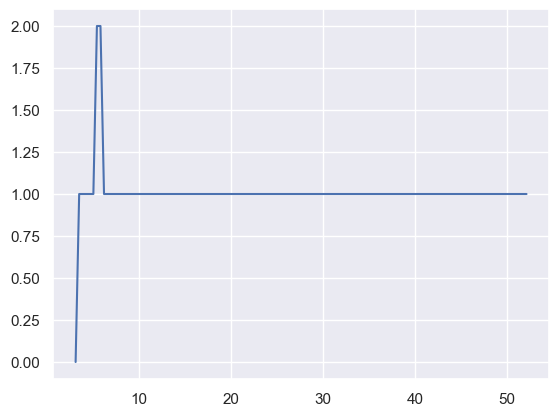

In [32]:
thresholds, chi = get_chi(T=0.01, F=0.9, offset=50.0, num_levels=128, sigma=1.5)
plt.plot(thresholds, chi)

#### Get Chi for all T and F values

In [33]:
T_vals = jnp.linspace(0.01, 10.0, 50)
F_vals = jnp.linspace(-1.1, 1.1, 60)

In [36]:
# Create arrays to store the results for all T and F values
num_T = len(T_vals)
num_F = len(F_vals)
num_levels = 128  # This is the number of threshold levels from get_chi
offset = 50.0
sigma = 1.5

results = {
    'T_vals': T_vals,
    'F_vals': F_vals,
    'all_thresholds': np.zeros((num_T, num_F, num_levels)),
    'all_chi': np.zeros((num_T, num_F, num_levels)),
}

In [37]:
# Calculate Euler characteristic for each pair of (T, F) values
for i, T in enumerate(tqdm(T_vals, desc="Processing T values")):
    for j, F in enumerate(tqdm(F_vals, desc=f"Processing F values for T={T:.2f}", leave=False)):
        thresholds, chi = get_chi(T=T, F=F, offset=offset, num_levels=num_levels, sigma=sigma)
        # Store all thresholds and chi values
        results['all_thresholds'][i, j, :] = thresholds
        results['all_chi'][i, j, :] = chi

Processing T values:   0%|          | 0/50 [00:00<?, ?it/s]

Processing F values for T=0.01:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=0.21:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=0.42:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=0.62:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=0.83:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=1.03:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=1.23:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=1.44:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=1.64:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=1.84:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=2.05:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=2.25:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=2.46:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=2.66:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=2.86:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=3.07:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=3.27:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=3.48:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=3.68:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=3.88:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=4.09:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=4.29:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=4.50:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=4.70:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=4.90:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=5.11:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=5.31:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=5.51:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=5.72:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=5.92:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=6.13:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=6.33:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=6.53:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=6.74:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=6.94:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=7.15:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=7.35:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=7.55:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=7.76:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=7.96:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=8.17:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=8.37:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=8.57:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=8.78:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=8.98:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=9.18:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=9.39:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=9.59:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=9.80:   0%|          | 0/60 [00:00<?, ?it/s]

Processing F values for T=10.00:   0%|          | 0/60 [00:00<?, ?it/s]

Cache results

In [ ]:
import pickle

with open("chi_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
from ipywidgets import interact, IntSlider

import matplotlib.pyplot as plt

def plot_euler_characteristic(T_idx, F_idx):
    # Get the indices closest to the selected T and F values
    T_value = results['T_vals'][T_idx]
    F_value = results['F_vals'][F_idx]

    # Get the corresponding thresholds and chi values
    thresholds = results['all_thresholds'][T_idx, F_idx, :]
    chi = results['all_chi'][T_idx, F_idx, :]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, chi, 'b-', linewidth=2)
    plt.ylim(-1, 4)
    plt.xlabel('Threshold Value')
    plt.ylabel('Euler Characteristic (χ)')
    plt.title(f'Euler Characteristic vs Threshold (T={T_value:.2f}, F={F_value:.2f})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create interactive sliders
interact(
    plot_euler_characteristic,
    T_idx=IntSlider(min=0, max=num_T-1, step=1, value=num_T//2, description='T index'),
    F_idx=IntSlider(min=0, max=num_F-1, step=1, value=num_F//2, description='F index')
)


interactive(children=(IntSlider(value=25, description='T index', max=49), IntSlider(value=30, description='F i…

<function __main__.plot_euler_characteristic(T_idx, F_idx)>

### Jump count analysis

In [53]:
T_vals       = results["T_vals"]            # shape (50,)
F_vals       = results["F_vals"]            # shape (60,)
all_chi      = results["all_chi"]           # shape (50, 60, 128)

# Δχ between successive α‑levels, |Δχ| counts one Morse event
delta_chi    = np.abs(np.diff(all_chi, axis=2))     # shape (50,60,127)
jump_count   = delta_chi.sum(axis=2)                # shape (50,60)

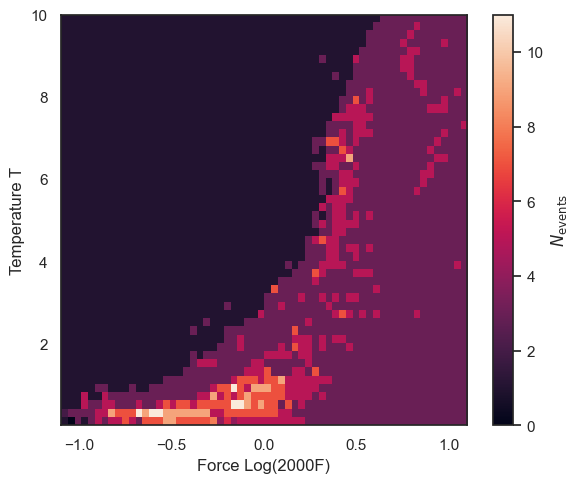

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

sns.set_theme(style="white")

im = ax.imshow(jump_count,            # 2‑D scalar field
               origin='lower',
               aspect='auto',
               extent=[F_vals[0], F_vals[-1], T_vals[0], T_vals[-1]])

ax.set_xlabel("Force Log(2000F)")
ax.set_ylabel("Temperature T")
cbar = fig.colorbar(im, ax=ax, label=r"$N_\mathrm{events}$")

plt.tight_layout()
plt.show()

### Plataeu height

In [ ]:
T_vals       = results["T_vals"]             # (50,)
F_vals       = results["F_vals"]             # (60,)
alpha_grid   = results["all_thresholds"]     # (50,60,128)
chi_grid     = results["all_chi"]            # (50,60,128)

# χ_min(T,F) needed for the baseline
chi_min      = chi_grid.min(axis=2, keepdims=True)        # (50,60,1)

# integrand = |χ - χ_min|
abs_curve    = np.abs(chi_grid - chi_min)                 # (50,60,128)

# area under the curve via the trapezoidal rule for *non‑uniform* α
area_map = np.trapezoid(abs_curve, x=alpha_grid, axis=2)      # (50,60)

In [70]:
# divide by range of α so units ~"average plateau height"
alpha_span = alpha_grid.max(axis=2) - alpha_grid.min(axis=2)   # (50,60)
area_norm  = area_map / alpha_span

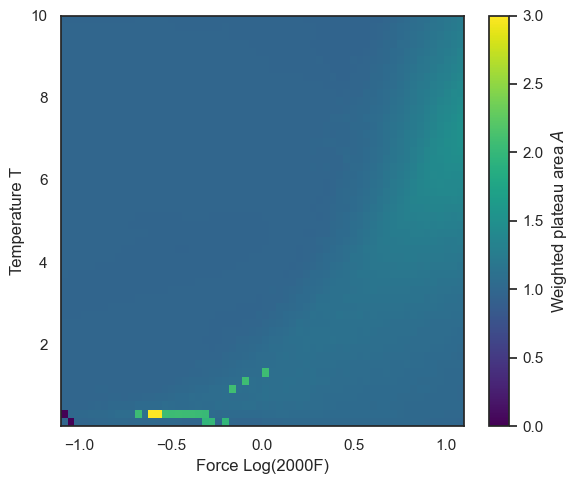

In [76]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(area_norm, origin="lower", aspect="auto",
               extent=[F_vals[0], F_vals[-1], T_vals[0], T_vals[-1]],
               vmin=0, vmax=3.0,
               cmap="viridis")          # or any perceptually uniform map
fig.colorbar(im, ax=ax, label=r"Weighted plateau area $A$")
ax.set_xlabel("Force Log(2000F)")
ax.set_ylabel("Temperature T")
plt.tight_layout(); plt.show()

Other metrics

In [78]:
chi = results["all_chi"]          # shape (NT, NF, Nα)
alpha = results["all_thresholds"] # same shape
dα = np.diff(alpha, axis=2)       # α_k+1 – α_k  (NT,NF,Nα-1)
Δχ = np.diff(chi, axis=2)         # χ_k+1 – χ_k
absΔχ = np.abs(Δχ)
α_span = alpha[..., -1] - alpha[..., 0]      # total α­range  (NT,NF)

### Event density

$D = \frac{\sum |Δχ|}{\alpha_{\max}-\alpha_{\min}}$

Counts how many birth/death events occur per unit energy.
Rises when lots of shallow minima/saddles appear.

In [79]:
D = absΔχ.sum(axis=2) / α_span          # (NT,NF)

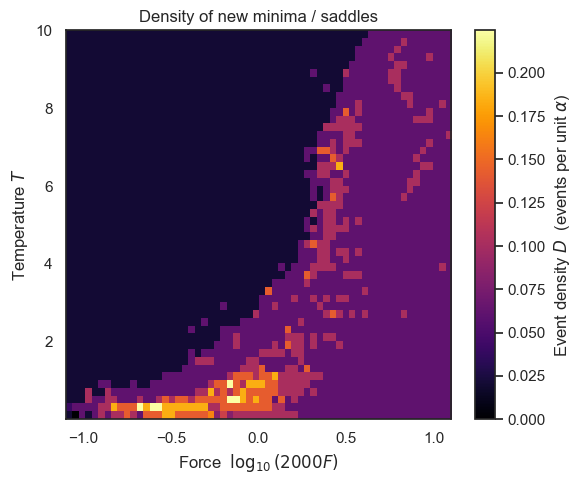

In [94]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(D, origin='lower', aspect='auto',
               extent=[F_vals[0], F_vals[-1], T_vals[0], T_vals[-1]],
               cmap='inferno')
fig.colorbar(im, ax=ax, label=r'Event density $D$  (events per unit $\alpha$)')
ax.set_xlabel(r'Force  $\log_{10}(2000F)$')
ax.set_ylabel(r'Temperature $T$')
ax.set_title('Density of new minima / saddles')
plt.tight_layout(); plt.show()

### Plateau‑weighted jump size

$P = \sum |Δχ| \,\Delta\alpha$

Same as the “area under $|χ–χ_min|$” but easier to compute directly from
Δχ and the local α‑step:

In [97]:
P = (absΔχ * dα).sum(axis=2)            # (NT,NF)

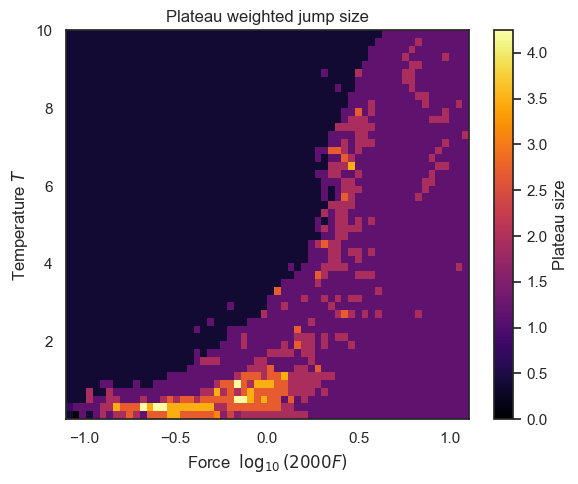

In [100]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(P, origin='lower', aspect='auto',
               extent=[F_vals[0], F_vals[-1], T_vals[0], T_vals[-1]],
               cmap='inferno')
fig.colorbar(im, ax=ax, label=r'Plateau size')
ax.set_xlabel(r'Force  $\log_{10}(2000F)$')
ax.set_ylabel(r'Temperature $T$')
ax.set_title('Plateau weighted jump size')
plt.tight_layout(); plt.show()

### Signed chi integral

$I = \displaystyle\int\! \chi(\alpha)\,d\alpha$

Positive when components dominate, negative when holes dominate.

In [83]:
I = np.trapezoid(chi, x=alpha, axis=2)      # (NT,NF)

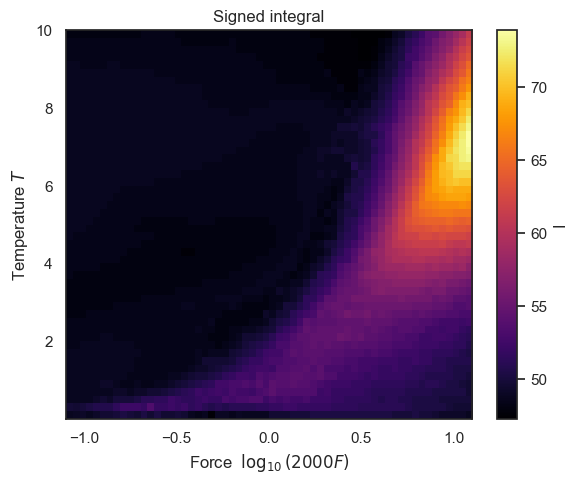

In [102]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(I, origin='lower', aspect='auto',
               extent=[F_vals[0], F_vals[-1], T_vals[0], T_vals[-1]],
               cmap='inferno')
fig.colorbar(im, ax=ax, label=r'I')
ax.set_xlabel(r'Force  $\log_{10}(2000F)$')
ax.set_ylabel(r'Temperature $T$')
ax.set_title('Signed integral')
plt.tight_layout(); plt.show()

### Earliest significant jump

Energy at which |χ| first changes by ≥ 2.

In [105]:
mask = absΔχ >= 2
idx_first = mask.argmax(axis=2)                     # 0 if never true
has_jump  = mask.any(axis=2)
α_first_jump = np.where(has_jump,
                        np.take_along_axis(alpha[...,1:], idx_first[...,None], 2)[...,0],
                        np.nan)

Good for seeing where a qualitatively new basin (or pair of basins)
is born.

Plot α_first_jump with cmap='viridis'; NaNs → no big jump detected.

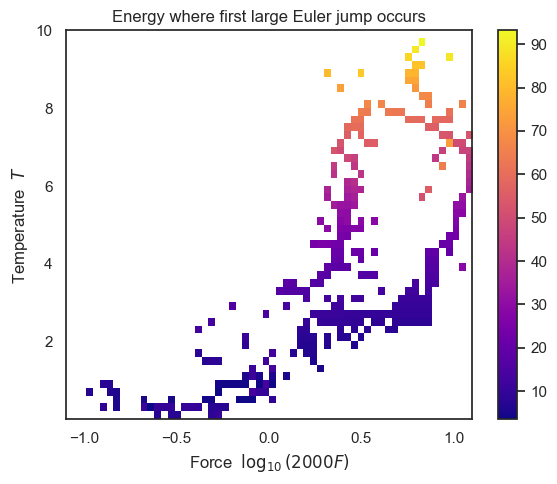

In [109]:
# --- mask NaNs so they appear as blank/white cells --------------------------
alpha_map = np.ma.masked_invalid(α_first_jump)   # (NT, NF)

fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(alpha_map,
               origin='lower',            # T_vals[0], F_vals[0] in lower‑left
               aspect='auto',
               extent=[F_vals[0], F_vals[-1],    # x‑axis  (F)
                       T_vals[0], T_vals[-1]],   # y‑axis  (T)
               cmap='plasma')              # or 'viridis', 'magma', …

cbar = fig.colorbar(im, ax=ax)

ax.set_xlabel(r'Force  $\log_{10}(2000F)$')
ax.set_ylabel(r'Temperature  $T$')
ax.set_title(r'Energy where first large Euler jump occurs')
plt.tight_layout()
plt.show()

## Method 2: Persistent cohomology

<!-- TODO -->